In [25]:
!pip install pandas numpy matplotlib scikit-learn torch torchvision tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 630.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 2.2 MB/s eta 0:00:00


In [2]:
# Check torch is using cuda
import torch
torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4060 Ti'

In [32]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import cm

import torch
from torchvision import datasets, transforms

def is_notebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True  # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False  # Probably standard Python interpreter

if is_notebook():
    # from tqdm import tqdm_notebook as tqdm
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm

In [6]:
# From https://jakevdp.github.io/PythonDataScienceHandbook/06.00-figure-code.html#Principal-Components-Rotation
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

def project_points(src, tgt, ax=None, color='red'):
    ax = ax or plt.gca()
    src2 = tgt * np.dot(src, tgt) / np.linalg.norm(tgt)
    ax.plot([src[0], src2[0]], [src[1], src2[1]], color=color, lw=.7)

def draw_projection(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=.8,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

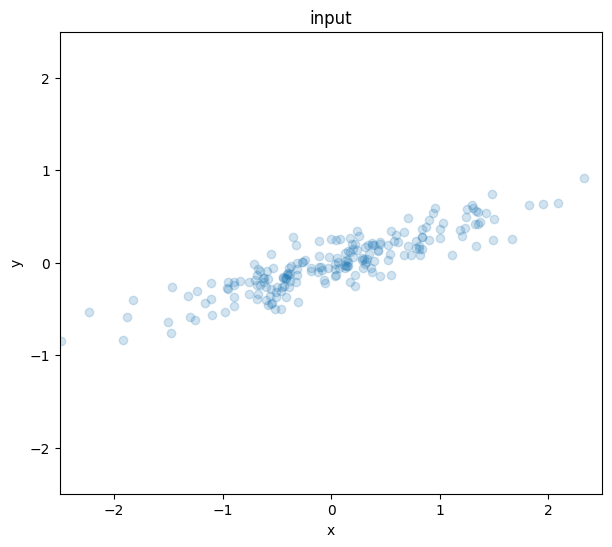

In [4]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T

fig, ax = plt.subplots(1, 1, figsize=(7, 6))

# plot data
ax.scatter(X[:, 0], X[:, 1], alpha=0.2)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set(xlabel='x', ylabel='y', title='input')
plt.show()

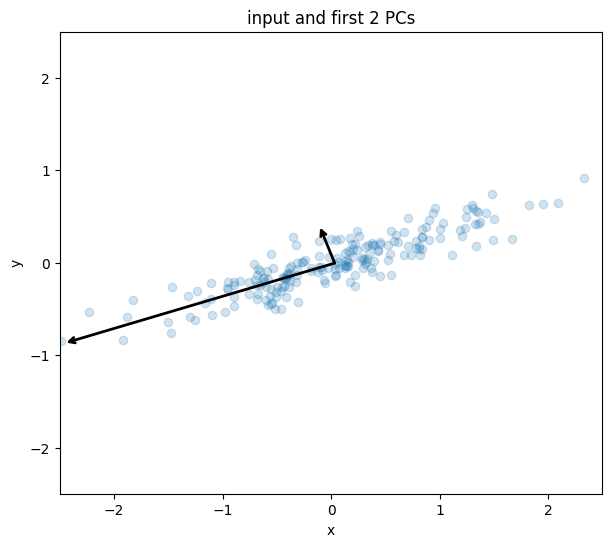

In [7]:
pca = PCA(n_components=2, whiten=True)
pca.fit(X)

# plot data
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax)

ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set(xlabel='x', ylabel='y', title='input and first 2 PCs');

## Projections

Projection is the location on a target vector to which another point/vector maps orthogonally.

The figure below shows the projection of some of the points onto the first PC.

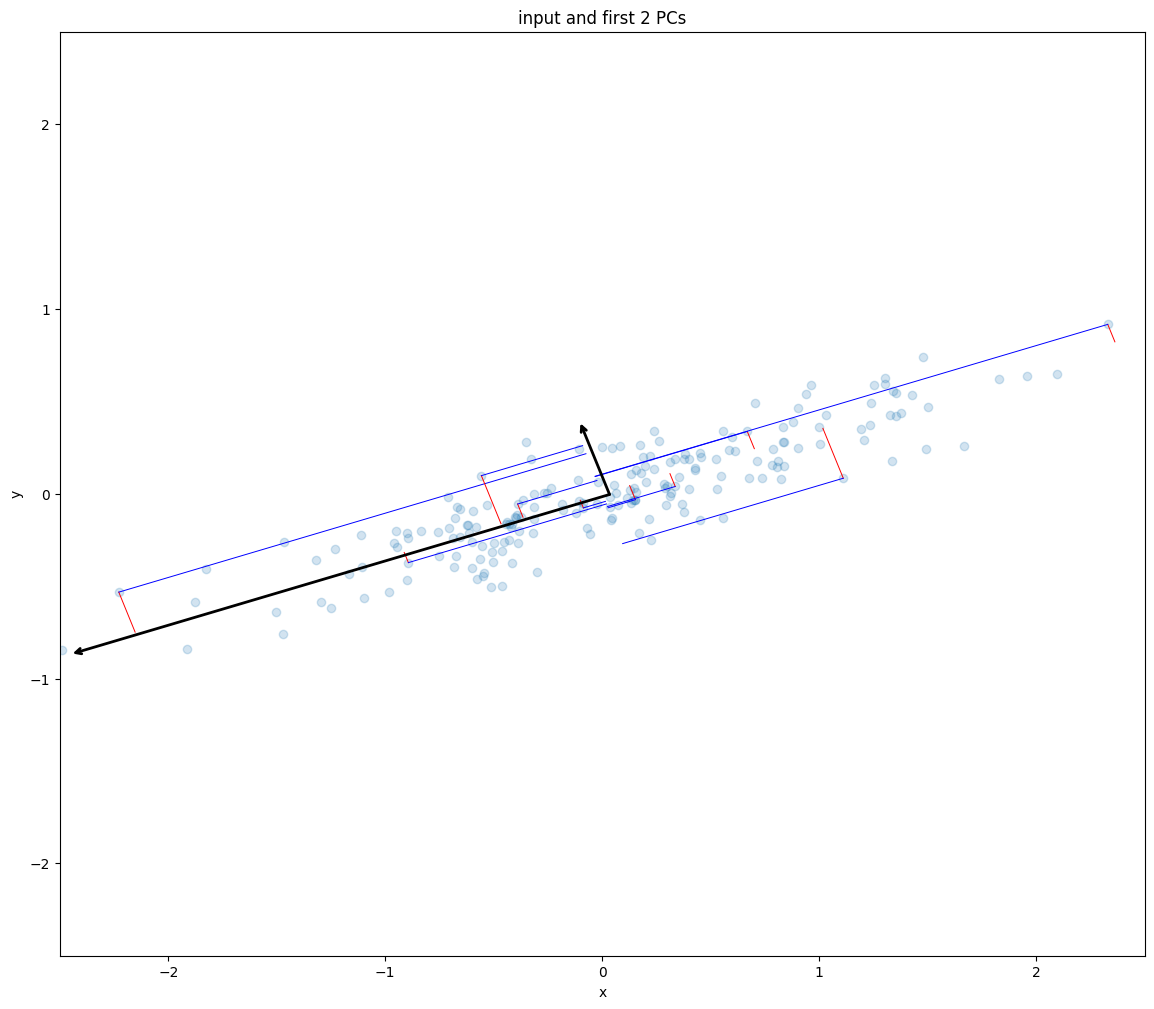

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
ax.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax)

pts = X.copy()
pts = pts[np.argsort( pts[:, 0] ), :]
pts = pts[1::22]
for pt in pts:
    project_points(pt, pca.components_[0], ax, color='red')
    project_points(pt, pca.components_[1], ax, color='blue')

ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set(xlabel='x', ylabel='y', title='input and first 2 PCs');

Since the PCs are orthogonal, we can call them axes and apply rotations so that they map onto Cartesian coordinates.

Furthermore, we can normalize each vector to rescale the points along each axis.

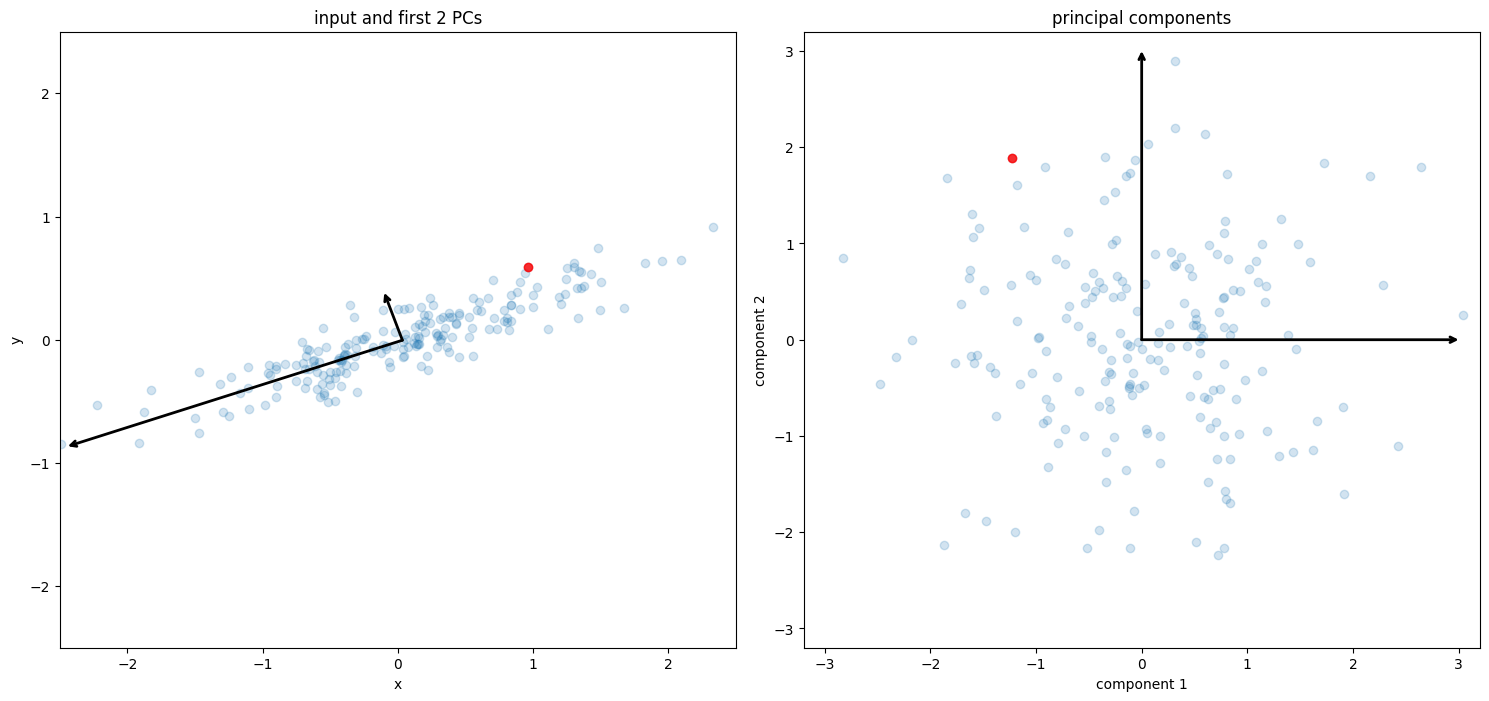

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# plot data
ax[0].scatter(X[:, 0], X[:, 1], alpha=0.2)
ax[0].scatter(X[1, 0], X[1, 1], alpha=0.8, color='red')
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0])
# ax[0].axis('equal');
ax[0].set(xlabel='x', ylabel='y', title='input')
ax[0].set_xlim(-2.5, 2.5)
ax[0].set_ylim(-2.5, 2.5)
ax[0].set(xlabel='x', ylabel='y', title='input and first 2 PCs');

# plot principal components
X_pca = pca.transform(X)

ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)
ax[1].scatter(X_pca[1, 0], X_pca[1, 1], alpha=0.8, color='red')

draw_vector([0, 0], [0, 3], ax=ax[1])
draw_vector([0, 0], [3, 0], ax=ax[1])
# ax[1].axis('equal')
ax[1].set(xlabel='component 1', ylabel='component 2',
          title='principal components',
          xlim=(-5, 5), ylim=(-3, 3.1))
ax[1].set_xlim(-3.2, 3.2)
ax[1].set_ylim(-3.2, 3.2);

We can apply the inverse transform and see that we get the same points back.

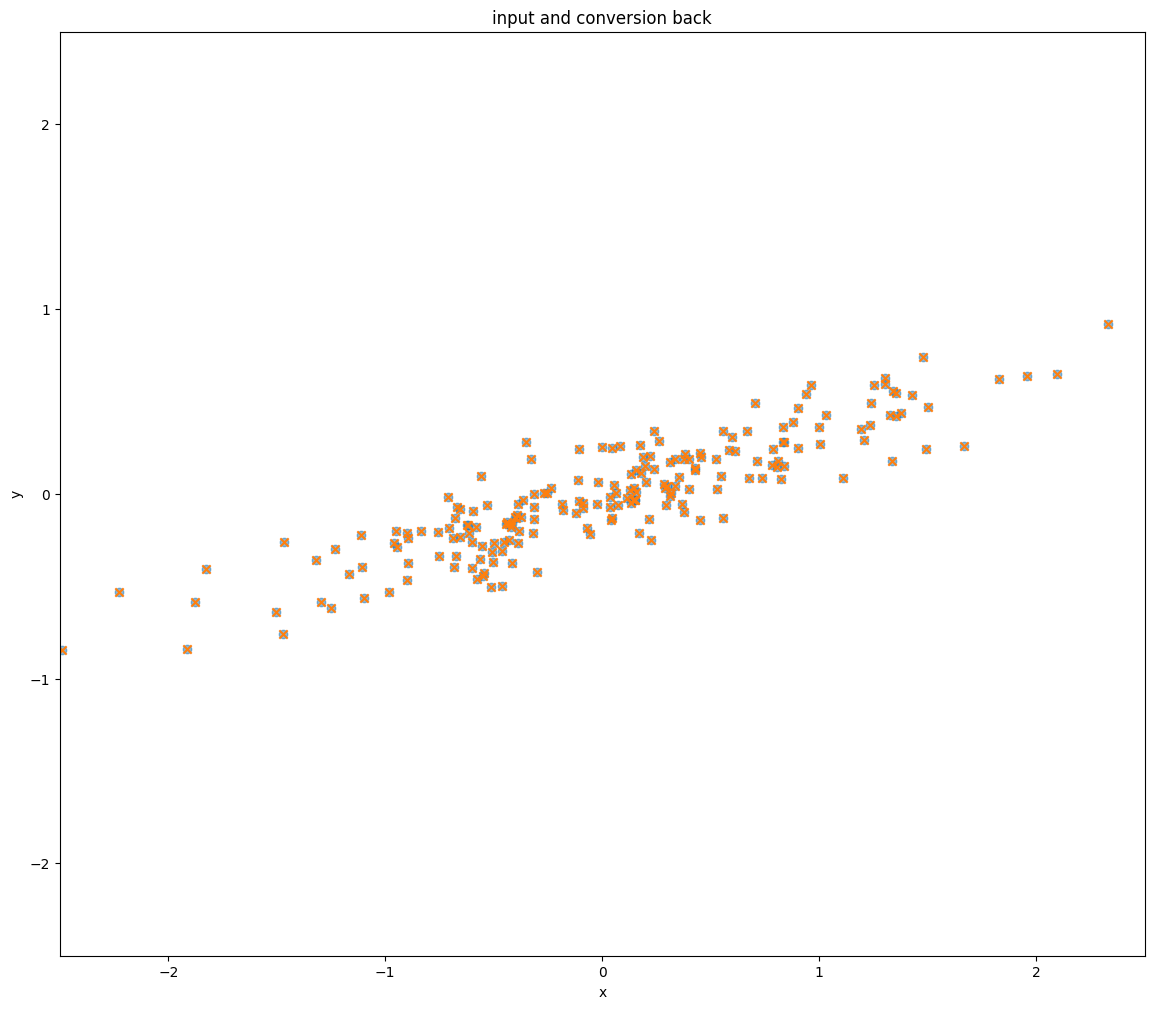

In [10]:
Y = pca.inverse_transform(X_pca)
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
ax.scatter(X[:, 0], X[:, 1], alpha=0.5)
ax.scatter(Y[:, 0], Y[:, 1], alpha=1., marker='x')
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set(xlabel='x', ylabel='y', title='input and conversion back');

* The length of the eigenvector is proportionally relevant to the variance explained.

* Above, for visualization purposes, the square root of the eigenvalue (the magnitude of the eigenvector) was used.

In [11]:
print(f'The amount of variance explained by the first PC is {pca.explained_variance_[0]:.3f}')
print(f'The amount of variance explained by the second PC is {pca.explained_variance_[1]:.3f}')
print(f'Total amount of variance explained by the first two PCs is {np.sum(pca.explained_variance_):.3f}')
print(f'Proportional amount of variance explained: {pca.explained_variance_ratio_[0]:.3f}, {pca.explained_variance_ratio_[1]:.3f}')

The amount of variance explained by the first PC is 0.763
The amount of variance explained by the second PC is 0.018
Total amount of variance explained by the first two PCs is 0.781
Proportional amount of variance explained: 0.976, 0.024


##Correlation Matrix

* The difference between the covariance matrix and the correlation matrix, is that the correlation matrix is normalized so that the min and max are [-1, 1]. -1, is perfectly anti-correlated and 1 is perfectly correlated. 0 has no correlation.

* Given the data, X, where rows are the samples and the columns are the features, we can ask for the pairwise correlation between the columns and get a n_column by n_column correlation matrix:

In [12]:
cor_x = np.corrcoef(X.T)
print(f'Correlation Matrix:\n {cor_x}')

Correlation Matrix:
 [[1.         0.88938995]
 [0.88938995 1.        ]]


* The diagonal will be ones because rowcolumn[i] is perfectly correlated with itself.

* The matrix should reflect about the diagonal because correlation does not consider direction, so really all we need is a triangular matrix.

* The above shows that there is nearly 90% correlation between the first and second columns of the data.

* Again, this was also supported by the first principal component explaining so much of the data -- if there is high correlation, the second component will not give us much of anything unique.

The eigenvectors and values of our correlation matrix are:

In [13]:
eig_vals, eig_vecs = np.linalg.eig(cor_x)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]

Eigenvalues 
[0.11061005 1.88938995]


# PCA with MNIST

We will now consider PCA with MNIST images. We will use Pytorch simply for the data loading.

In [ ]:
batch_size = 32

train_dataset = datasets.MNIST('./data',
                               train=True,
                               download=True,
                               transform=transforms.Compose([
                       transforms.ToTensor(),
#                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

test_dataset = datasets.MNIST('./data',
                                    train=False,
                               transform=transforms.Compose([
                       transforms.ToTensor(),
#                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                batch_size=batch_size,
                                                shuffle=False)

images = train_loader.dataset.data.detach().numpy().reshape(-1, 28*28)
print(f'Num training images: {len(images)},\tmin val: {images.min():.3f},\tmax val: {images.max():.3f}')

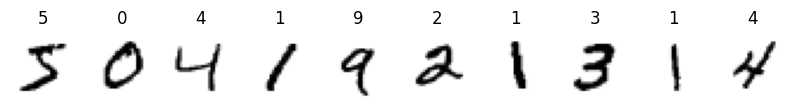

In [15]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize*1.1))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(train_loader.dataset.data[i].numpy().reshape(28,28), cmap="gray_r")
    plt.title(str(train_loader.dataset.targets[i].item()))

In [16]:
%%time
c = np.nan_to_num(np.corrcoef(images.T))  # Normalized [-1, 1] covariance matrix
# c = np.cov(images.T)

CPU times: user 1.59 s, sys: 1.48 s, total: 3.07 s
Wall time: 380 ms


/home/sonnh11/study/sdh/ml/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/sonnh11/study/sdh/ml/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [17]:

c.shape, c.min(), c.max()

((784, 784), -0.4326772195764491, 1.0)

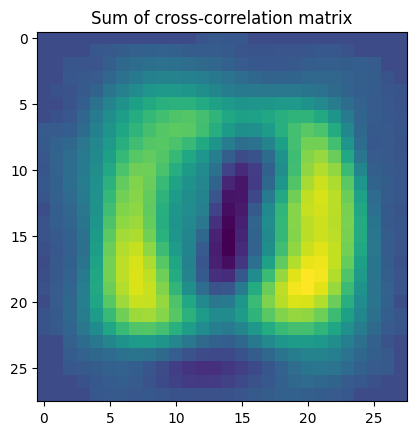

In [18]:
fig = plt.figure()
plt.imshow(c.sum(axis=0).reshape(28,28), interpolation='nearest')
plt.title('Sum of cross-correlation matrix');

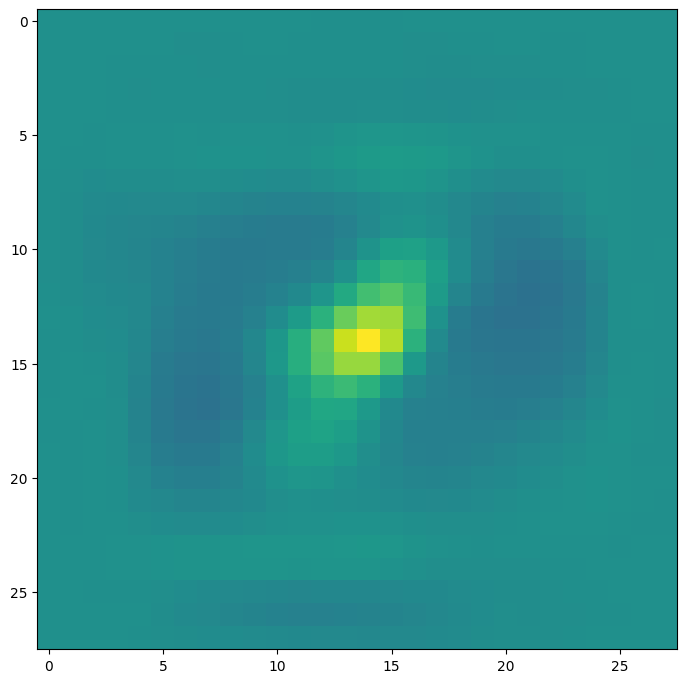

In [19]:
side_dim = 28
data = c.reshape(side_dim, side_dim, side_dim, side_dim)
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([.1, .1, .8, .8])
implot = ax.imshow(data[side_dim>>1, side_dim>>1].reshape(side_dim, side_dim),
                   interpolation='nearest', clim=(-1,1))
text=ax.text(-.5,-1, "", va="bottom", ha="left")

last_x, last_y = -1, -1

def onmotion(event):
    global last_x
    global last_y
    global data
    global side_dim
    global text
    global implot
    x = int(np.rint(event.xdata))
    y = int(np.rint(event.ydata))
    if last_x != x or last_y != y and x >=0 and y >= 0:
#         plt.cla()  # Try and see if this keeps it from bogging down with more and more interactivity.
        implot.set_array(data[y, x].reshape(side_dim, side_dim))
        last_x = x
        last_y = y
#     tx = 'x=%d, y=%d, xdata=%f, ydata=%f, x=%d, y=%d' % \
#     (event.x, event.y, event.xdata, event.ydata, x, y)
#     text.set_text(tx)

cid = implot.figure.canvas.mpl_connect('motion_notify_event', onmotion)

## First PCs of MNIST

Let's look at the first principal components as derived from PCA:

CPU times: user 15.8 s, sys: 5.46 s, total: 21.3 s
Wall time: 1.93 s


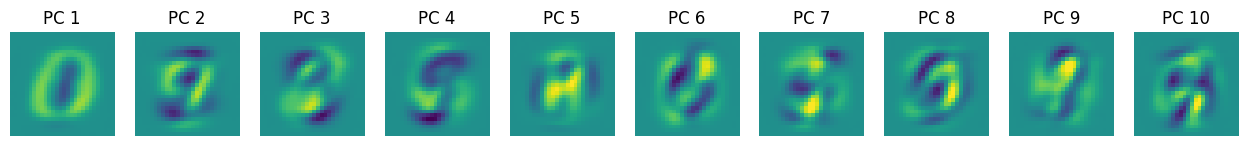

In [20]:
%%time
n_components = 10
pca = PCA(n_components=n_components)
pca.fit(images)
fig = plt.figure(figsize=(n_components*np.power(n_components, 1/5),3))
axes = []
for i in range(n_components):
    ax_ = fig.add_subplot(1, n_components, i+1)
    ax_.imshow(pca.components_[i].reshape(28,28), interpolation='nearest', clim=(-.15, .15));
    ax_.set_title(f'PC {i+1}')
    ax_.axis('off')

    axes.append(ax_)

CPU times: user 34.1 s, sys: 11.7 s, total: 45.9 s
Wall time: 4.15 s


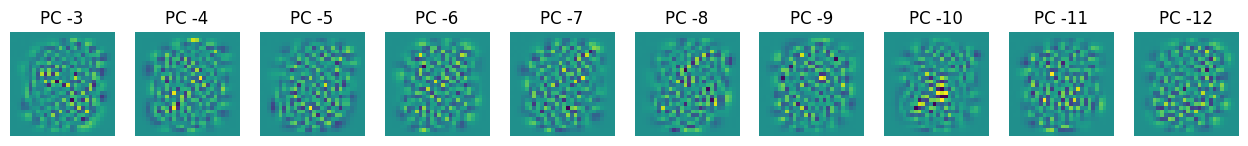

In [21]:
%%time
n_components = 10
pca = PCA(n_components=233)
pca.fit(images)
fig = plt.figure(figsize=(n_components*np.power(n_components, 1/5),3))
axes = []
for i in range(n_components+1, 1, -1):
    ax_ = fig.add_subplot(1, n_components, i-1)
    ax_.imshow(pca.components_[-i].reshape(28,28), interpolation='nearest', clim=(-.15, .15));
    ax_.set_title(f'PC {-i-1}')
    ax_.axis('off')
    axes.append(ax_)

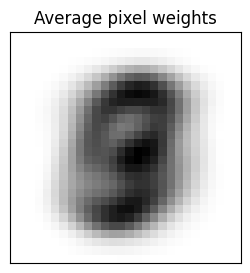

Max of mean: 139.5536


In [22]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.matshow(images.mean(axis=0).reshape(28, 28), cmap = cm.binary)
# ax.plot(pca.mean_)
plt.xticks(np.array([]))
plt.yticks(np.array([]))
plt.title('Average pixel weights')
plt.show()
print("Max of mean:", images.mean(axis=0).max())

## Effect of iterative PCs

Consider the impact of applying PCs.

In [23]:
# We will apply a Fibonacci sequence for illustrative purposes.
def fib(n):
    a, b = 1, 2  # Normally we'd start at 0, 1, but we don't want that...
    for _ in range(n):
        yield a
        a, b = b, a + b

/tmp/ipykernel_840/2161131727.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(fib(n_components), total=n_components):


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

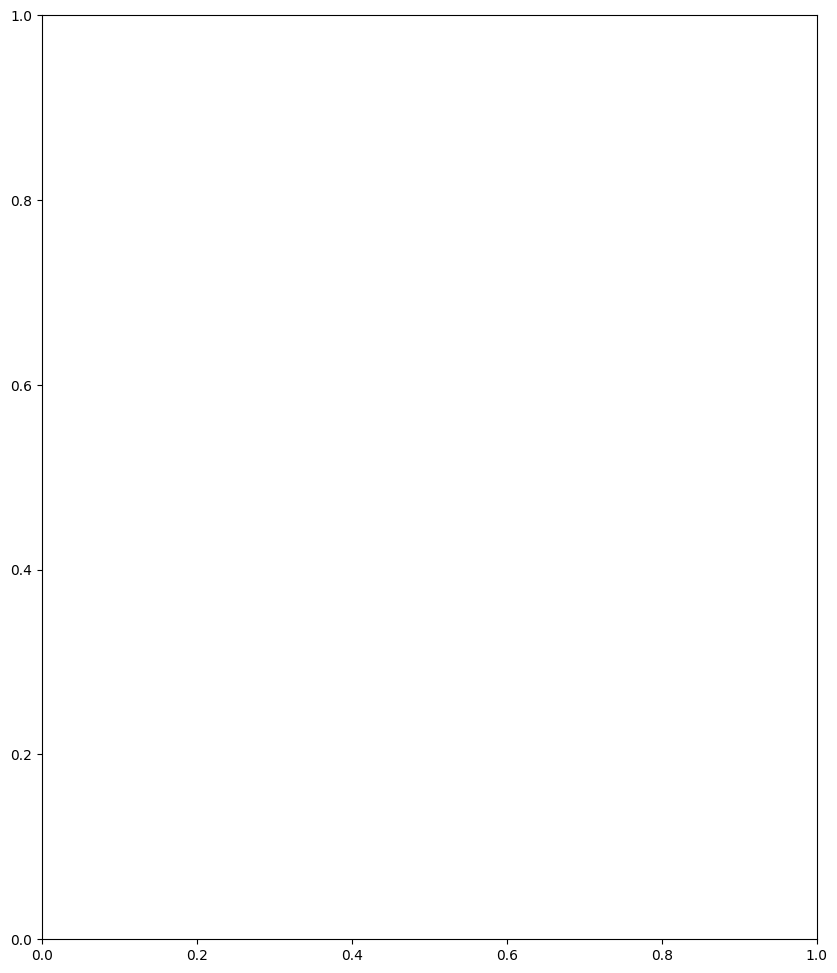

In [33]:
# Try PCA on first ten test images
n_images = 8
n_components = 12
test_images = np.array(test_loader.dataset.data[:n_images].numpy().reshape((n_images,784)))
# Plot the first ten test images and the corresponding outputs
fig = plt.figure(figsize=(10, n_components))
ax = fig.add_subplot(111)
images_in = [test_images[j].reshape(-1, 28) for j in range(n_images)]
image = np.concatenate(images_in, axis=1)

for i in tqdm(fib(n_components), total=n_components):
    pca = PCA(n_components=i)
    pca.fit(images)
    test_outputs = pca.inverse_transform(pca.transform(test_images))
    images_out = [test_outputs[j].reshape(-1, 28) for j in range(n_images)]
    image_out = np.concatenate(images_out, axis=1)
    image = np.concatenate([image, image_out])
ax.matshow(image, cmap = cm.binary)
ax.set_xticks(np.array([]))
y_lim = ax.get_ylim()
y_scale = (y_lim[0] - y_lim[1])/(n_components+1)
ax.set_yticks(np.linspace(.5, n_components+.5, n_components+1) * y_scale)
a = [0]
a.extend(list(fib(n_components)))
ax.set_yticklabels(a)
plt.show()

## Closer inspection.

Consider the application of the first PC to the first image.

PC_0 min: -0.0768,	PC_0 max: 0.1062
mean_img min: 0.0000,	mean_img max: 139.5536
Ammount to apply: -332.2712
PC_0 min: -0.0768,	PC_0 max: 0.1062
mean_img min: 0.0000,	mean_img max: 139.5536
Ammount to apply: 1233.9070


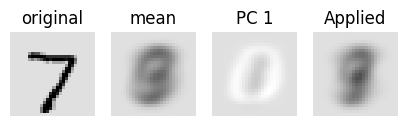

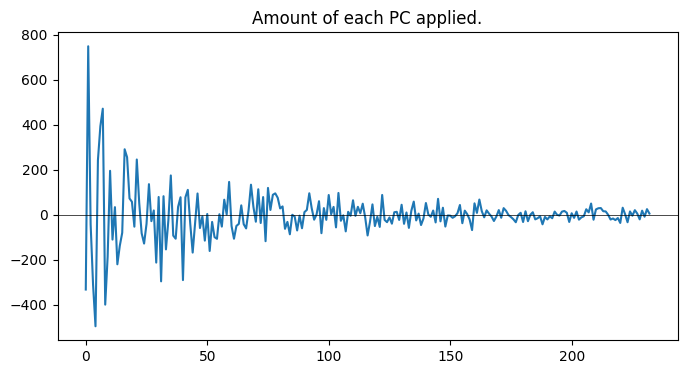

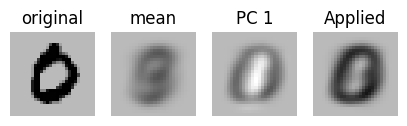

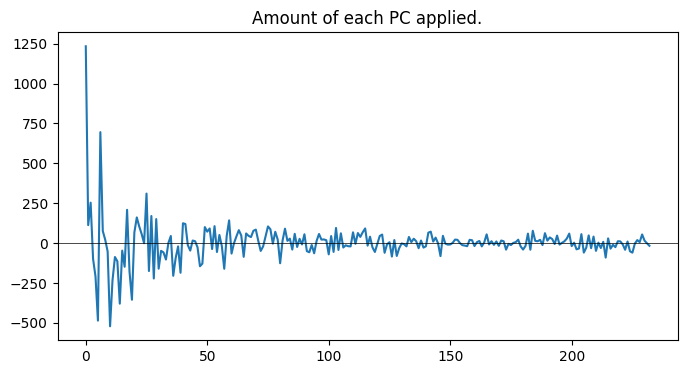

In [ ]:
def draw_apply_PC0(idx):
    fig = plt.figure(figsize=(5,3))
    pca0_applied = pca.components_[0].reshape(28, 28) * pca.transform(test_images)[idx][0]
    image = pca.mean_.reshape(28, 28) + pca0_applied

    absmin = np.min([test_images[idx].min(), pca.mean_.min(), pca0_applied.min(), image.min()])
    absmax = np.max([test_images[idx].max(), pca.mean_.max(), pca0_applied.max(), image.max()])

    ax_ = fig.add_subplot(1, 4, 1)
    ax_.imshow(test_images[idx].reshape(28,28), interpolation='nearest', clim=(absmin, absmax), cmap = cm.binary);
    ax_.set_title(f'original')
    ax_.axis('off')

    ax_ = fig.add_subplot(1, 4, 2)
    ax_.imshow(pca.mean_.reshape(28,28), interpolation='nearest', clim=(absmin, absmax), cmap = cm.binary);
    ax_.set_title(f'mean')
    ax_.axis('off')

    ax_ = fig.add_subplot(1, 4, 3)
    ax_.imshow(pca0_applied, interpolation='nearest', clim=(absmin, absmax), cmap = cm.binary);
    ax_.set_title(f'PC 1')
    ax_.axis('off')

    ax_ = fig.add_subplot(1, 4, 4)
    ax_.imshow(image, interpolation='nearest', clim=(absmin, absmax), cmap = cm.binary);
    ax_.set_title(f'Applied')
    ax_.axis('off')

    print(f'PC_0 min: {pca.components_[0].min():.4f},\tPC_0 max: {pca.components_[0].max():.4f}')
    print(f'mean_img min: {pca.mean_.min():.4f},\tmean_img max: {pca.mean_.max():.4f}')
    print(f'Ammount to apply: {pca.transform(test_images)[idx][0]:.4f}')

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    ax.plot(pca.transform(test_images[idx].reshape(1, -1)).flatten())
    ax.axhline(0, lw=.5, color='k') # horizontal lines

    ax.set_title('Amount of each PC applied.')

draw_apply_PC0(0)
draw_apply_PC0(3)